In [14]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pprint

print(spacy.__version__)

3.0.3


# Introduction

In this notebook, we assume that you have already populated your Wikidata (AKA "Method 2") database, which was shown in `notebooks/03-wikidata_kg.ipynb`.  We also will assume that you have run the Cypher queries found in `cypher_queries/queries.cql` to do things like update the node labels to the P31 values, segment out both model and holdback data, and create some basic embeddings.

### We begin by reconnecting to Neo4j...

In [15]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [3]:
conn = Neo4jConnection(uri="bolt://neo4j:7687", user="neo4j", pwd="kgDemo")

# Embedding visualization

We will begin by looking at whether our embeddings cluster at all in any reasonable way.  We have used a pretty high-dimensional space to create those embeddings though, so we will use t-SNE to do dimensionality reduction for the sake of visualization.  Here we have two categories with 1 = `is_place` and 0 = NOT `is_place`.  We ideally want our embeddings to cluster in some clear fashion to give us some assurances that we are going the right way.

### Note

We have not really done any tuning of our embeddings.  Embedding tuning is an art unto itself and beyond the scope of this demonstration.  However, the result will be, as you will see, that the embeddings don't cluster very well and the resulting ML models don't product super great results.  The following is more intended for demonstration purposes.  In a real-world, deployable application you will obviously want to put much more effort into creating embeddings that work for you.

In [4]:
def create_tsne_plot(emb_name='n.n2v_all_nodes', n_components=2, debug=False):
    
    query_string = '''
        MATCH (n:Model_Data)
        RETURN n.name, n.type, n.is_place AS category, {} AS vec
    '''.format(emb_name)
    model_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
    
    if debug:
        uniqueValues = model_df['category'].nunique()
        print(uniqueValues)
    
    X_emb = TSNE(n_components=n_components).fit_transform(list(model_df['vec']))
    
    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb],
        'label': model_df['category']
    })
    
    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls',2),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=500,
        alpha=0.75
    )
    ax.legend(prop={'size': 20})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show

    return tsne_df

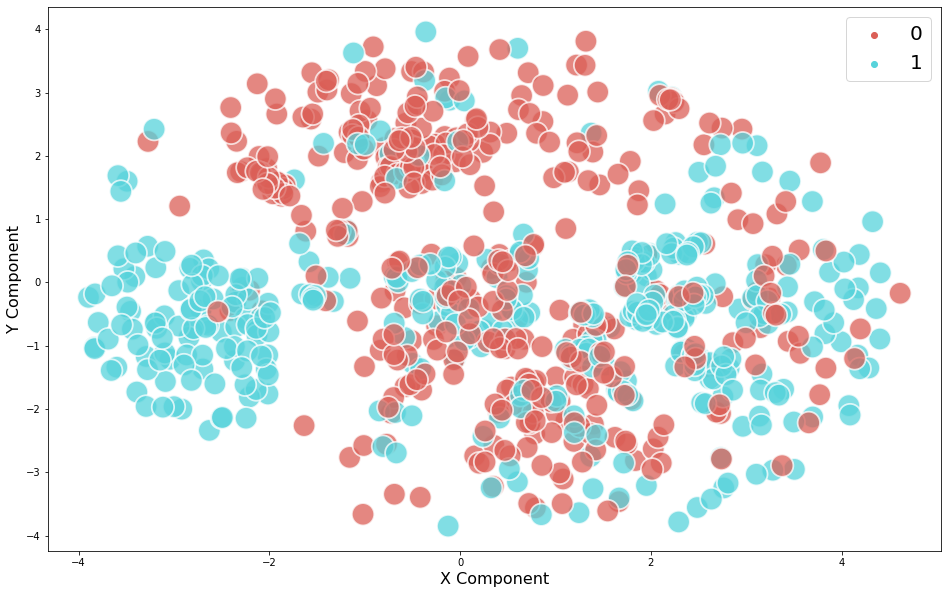

In [5]:
tsne_df = create_tsne_plot(emb_name='n.n2v_all_nodes', n_components=2, debug=False)

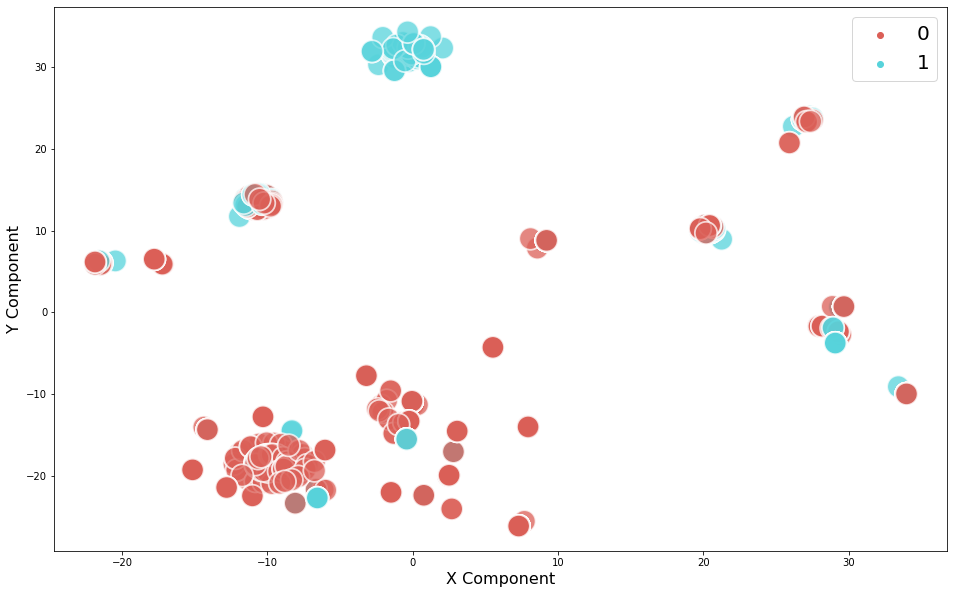

In [6]:
tsne_df = create_tsne_plot(emb_name='n.frp_all_nodes', n_components=2, debug=False)

# ML Modeling

There are many ways we could use these embeddings to create a model.  In this example, our goal will be binary classification to predict `is_place` given our different embeddings.  For the sake of simplicity, I am just going to create a support vector machine to demonstrate the general approach.  Obviously you can choose whatever classification model you would like.

### Note

Neo4j outputs its embeddings in a format that is not entirely compatible with `scikit-learn`.  So `create_X` is a helper function that will reformat those embeddings into something suitable.

In [7]:
def create_X(df2, emb):

    n2v_an_ls = df2[emb].to_list()
    n2v_arr = np.array([np.array(x) for x in n2v_an_ls], dtype=object)

    print(n2v_arr.shape)
    
    return n2v_arr


def modeler(df, emb_name, y_column_name, k_folds=5, model='linear', show_matrix=True):
    
    y = df[y_column_name].fillna(0.0).to_numpy()
    vec_array = create_X(df, emb_name)
    acc_scores = []
    
    pos = np.count_nonzero(y == 1.0)
    neg = y.shape[0] - pos
    print('Number of positive: ', pos, ' Number of negative: ', neg)
    
    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(vec_array, y, test_size=0.25)
        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return clf

In [9]:
query_string = '''
    MATCH (n:Model_Data)
    RETURN n.name, n.type, n.is_place AS category, n.n2v_all_nodes AS n2v_vec, n.frp_all_nodes AS frp_vec
'''
model_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
model_df.head()

,n.name,n.type,category,n2v_vec,frp_vec
0,United States of America,sovereign state,1,"[0.06254410743713379, 0.2595505714416504, -0.1...","[0.21622970700263977, 0.1671326756477356, -0.0..."
1,Democratic Party,political party,0,"[0.1259424239397049, 0.22953206300735474, -0.3...","[0.10498179495334625, 0.017325039952993393, -0..."
2,Illinois,state of the United States,1,"[-0.06240788474678993, -0.3062209486961365, -0...","[0.06931227445602417, 0.11020652204751968, -0...."
3,Hawaii,state of the United States,1,"[0.11160175502300262, -0.0274458397179842, -0....","[0.16305188834667206, 0.13411904871463776, 0.0..."
4,Chicago,city of the United States,1,"[0.09670834988355637, -0.013175737112760544, -...","[0.2338847666978836, -0.04192311689257622, 0.0..."


(823, 300)
Number of positive:  413  Number of negative:  410
Accuracy scores:  [0.6019417475728155, 0.6504854368932039, 0.6650485436893204, 0.6407766990291263, 0.6262135922330098]
Mean accuracy:  0.6368932038834951


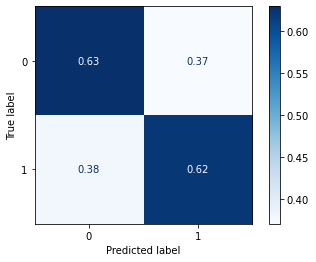

In [10]:
n2v_clf = modeler(model_df, emb_name='n2v_vec', y_column_name='category')

(823, 300)
Number of positive:  413  Number of negative:  410
Accuracy scores:  [0.7475728155339806, 0.7524271844660194, 0.7233009708737864, 0.7621359223300971, 0.7378640776699029]
Mean accuracy:  0.7446601941747573


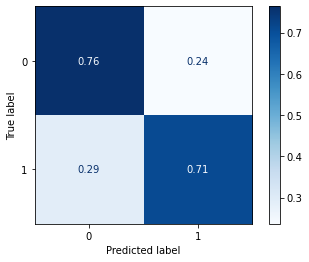

In [11]:
frp_clf = modeler(model_df, emb_name='frp_vec', y_column_name='category')

# Observation

So those accuracy scores were really nothing to write home about.  But how do the classifiers generated by the training handle predicting unknown data points?

For this, I am going to choose some nodes that I know to be places but that showed up as "Unknown" within the graph.  Some good ones are "city of the United States," "big city," and "historical unrecognized state."  Let's just give those a manual try and see what happens.

In [12]:
def predict_unknown(node_name, emb_name, clf, debug=False):
    
    query_string = "MATCH (n:Holdout_Data {name: '" + node_name + "'}) RETURN n.name AS name, n." + emb_name + " AS vec"
    
    if debug == True:
        print(query_string)
        print(type(query_string))
        print(emb_name)

    unknown_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
    
    vec_array = create_X(unknown_df, emb='vec')
    pred = clf.predict(vec_array)
    print('Predicted Class: ', pred[0])
    
    return

In [13]:
predict_unknown('city of the United States', 'n2v_all_nodes', clf=n2v_clf, debug=False)

(1, 300)
Predicted Class:  0


# Result

Disappointing, for sure.  But remember that we have spent no effort in optimizing either the embeddings nor the model.  It would take more time than we have in a 2 hour demonstration to do that.  There are plenty of resources out there to study up on this bit.  

# Next steps

1. Add more data to the graph (always a good idea when you can and time permits!)
2. Optimize the above embeddings (obvious)
3. Try GraphSAGE (advantage: takes into account node properties in addition to looking at random-walk approach)

## Important note

The Graph Data Science library does much more than embeddings!  In particular, I recommend you check out the [node classification](https://neo4j.com/docs/graph-data-science/current/algorithms/ml-models/node-classification/#algorithms-ml-nodeclassification) and [link prediction](https://neo4j.com/docs/graph-data-science/current/algorithms/ml-models/linkprediction/) modeling capabilities.  This small graph might not be able to take much advantage of them, but as the graph gets bigger you might find them to be really helpful!